In [1]:
from PIL import Image, ImageFilter
import os 
import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
# Load the jpg file into a numpy array
image_dir = '/mnt/c/Users/nikla/OneDrive - UvA/OADS_Backup/JPG'
face_result_dir = '/home/niklas/projects/oads_access/generated_annotations/faces/face_results.txt'

In [3]:
face_annotations_per_image = {}
with open(face_result_dir, 'r') as f:
    for line in f.readlines():
        line = line[:-1].split(',')
        filepath = line[0]
        filename = filepath.split('/')[-1]
        image_id = filename.split('.')[0]
        coordinates = [int(x) for x in line[1:]]

        if image_id in face_annotations_per_image.keys():
            face_annotations_per_image[image_id].append((coordinates, filename))
        else:
            face_annotations_per_image[image_id] = [(coordinates, filename)]

In [3]:
lp_result_dir = '/home/niklas/projects/oads_access/generated_annotations/license_plates/output'

In [4]:
from oads_access.license_plate_recognition_utils import *

In [7]:
license_plate_annotations_per_image = {}
for filename in os.listdir(lp_result_dir):
    # if filename.endswith('_lp.txt'):
    if filename.endswith('_cars.txt'):
        image_id = filename.split('_')[0]

        detected_car_labels = os.path.join(lp_result_dir, f'{image_id}_cars.txt')

        Lcar = lread(detected_car_labels)

        I = cv2.imread(os.path.join(image_dir, f'{image_id}.JPG'))

        if Lcar:

            for i,lcar in enumerate(Lcar):
                if os.path.exists(os.path.join(lp_result_dir, f'{image_id}_{i}car_lp.txt')):
                    lp_label = os.path.join(lp_result_dir, f'{image_id}_{i}car_lp.txt')
                    Llp_shapes = readShapes(lp_label)
                    pts = Llp_shapes[0].pts*lcar.wh().reshape(2,1) + lcar.tl().reshape(2,1)
                    ptspx = pts*np.array(I.shape[1::-1],dtype=float).reshape(2,1)

                    if image_id in license_plate_annotations_per_image:
                        license_plate_annotations_per_image[image_id].append((ptspx, filename))
                    else:
                        license_plate_annotations_per_image[image_id] = [(ptspx, filename)]

In [5]:
from result_manager.result_manager import ResultManager

result_manager = ResultManager(root='/home/niklas/projects/oads_access/generated_annotations')
# result_manager.save_result(result=license_plate_annotations_per_image, filename=f'license_plate_annotations_per_image.pkl')
# result_manager.save_result(result=face_annotations_per_image, filename=f'face_annotations_per_image.pkl')
license_plate_annotations_per_image = result_manager.load_result(filename=f'license_plate_annotations_per_image.pkl')
face_annotations_per_image = result_manager.load_result(filename=f'face_annotations_per_image.pkl')

In [8]:
target_dir = '/mnt/c/Users/nikla/OneDrive - UvA/OADS_Backup/Deidentified/JPG'
# fig, ax = plt.subplots(10,1, figsize=(20,65))

for index, (image_id, list) in tqdm.tqdm(enumerate(license_plate_annotations_per_image.items()), total=len(license_plate_annotations_per_image.items())):
    # if index >= 100:
    #     break

    # filename = list[0][1]
    img = np.array(Image.open(os.path.join(image_dir, f'{image_id}.JPG')))

    # Draw License plate annotations
    for box, filename in list:
        img, corners = draw_losangle(I=img,pts=box,color=(255,0,0),thickness=10)

    if image_id in face_annotations_per_image.keys():
        tup = face_annotations_per_image[image_id]

        for coordinates, _ in tup:
            top, right, bottom, left = coordinates
            tr = (right, top)
            tl = (left, top)
            br = (right, bottom)
            bl = (left, bottom)
            img = cv2.line(np.array(img), tr, tl, (255,0,0), 18)
            img = cv2.line(img, tl, bl, (255,0,0), 18)
            img = cv2.line(img, bl, br, (255,0,0), 18)
            img = cv2.line(img, br, tr, (255,0,0), 18)
            # ax[index, 0].add_patch(rec)

            # # Blur
            # box = (left, top, right, bottom)
            # crop_img = img.crop(box)
            # # Use GaussianBlur directly to blur the image 10 times. 
            # blur_image = crop_img.filter(ImageFilter.GaussianBlur(radius=10))
            # img.paste(blur_image, box)

    # ax[index].imshow(img)
    # Save image
    if type(img) == np.ndarray:
        img = Image.fromarray(img)

    img.save(fp=os.path.join(target_dir, f'{image_id}.JPG'))

100%|██████████| 2804/2804 [21:54<00:00,  2.13it/s]


[((672, 698), (736, 689)), ((736, 689), (736, 704)), ((736, 704), (672, 712)), ((672, 712), (672, 698))]


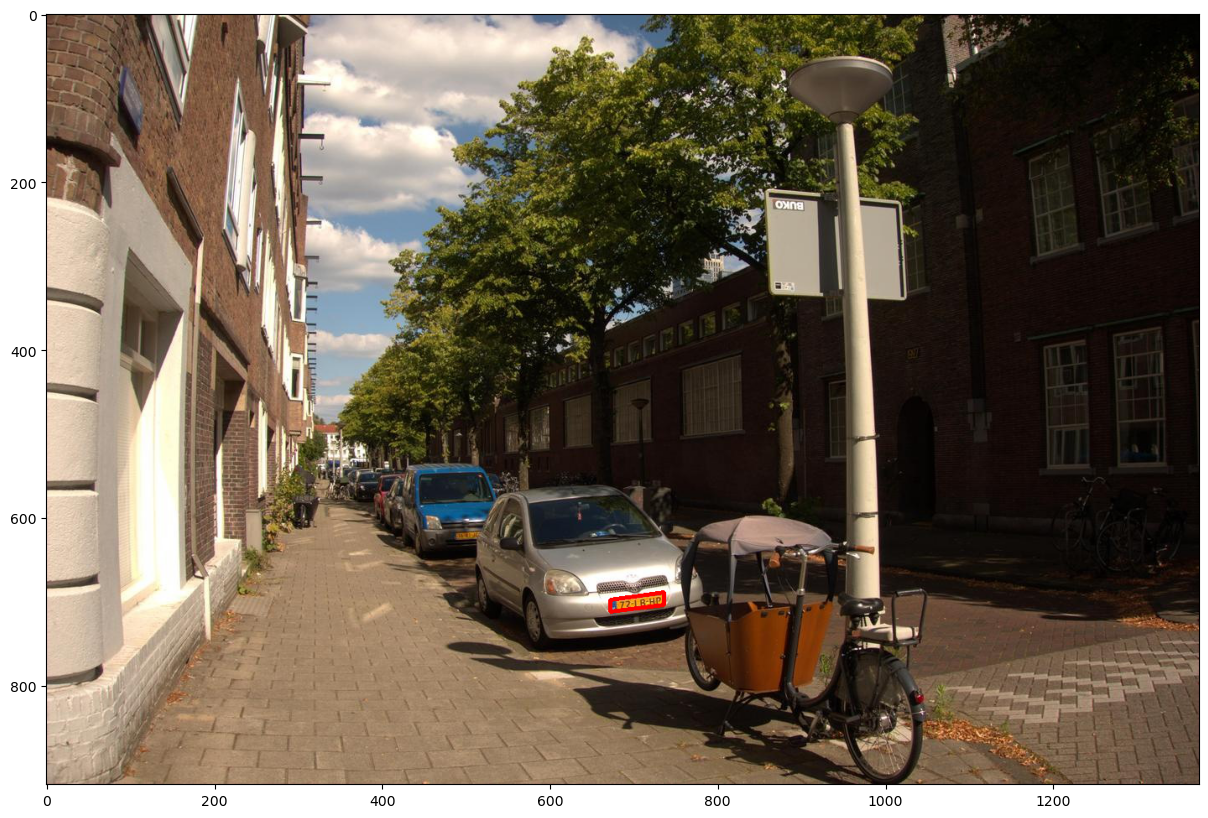

In [29]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

for index, (name, boxes) in enumerate(license_plate_annotations_per_image.items()):
    if index < 3:
        continue
    img = np.array(Image.open(os.path.join(image_dir, f'{name}.JPG')))
    for box, filename in boxes:
        # print(box)
        img, corners = draw_losangle(I=img,pts=box,color=(255,0,0),thickness=4)
        print(corners)
        # break
    
    ax.imshow(img)

    break

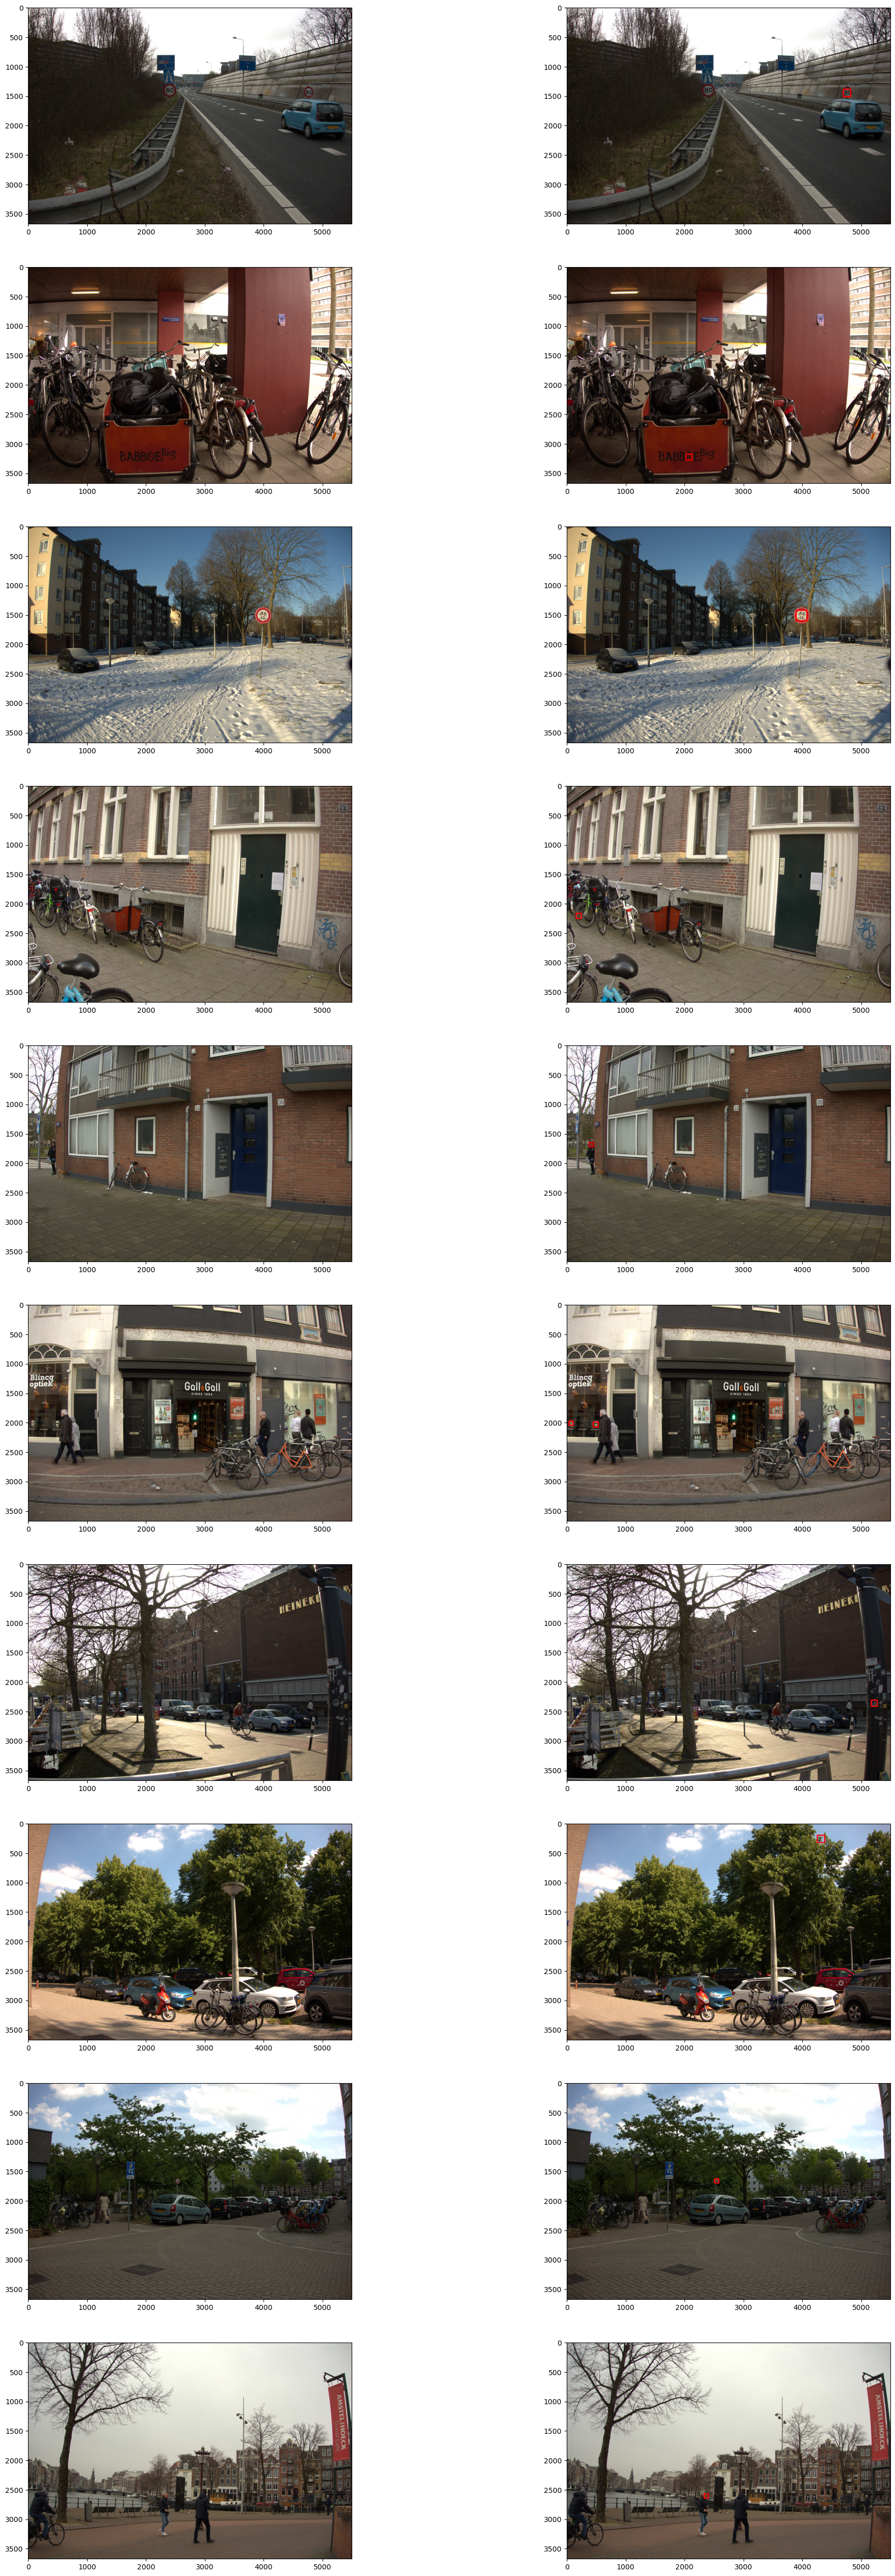

In [42]:
n = 10
fig, ax = plt.subplots(n,2, figsize=(25,65))

# for index, (image_id, tup) in enumerate(face_annotations_per_image.items()):
index = 0
for image_id in np.random.choice(a=list(face_annotations_per_image.keys()), size=n):
    tup = face_annotations_per_image[image_id]
    if index >= n:
        break
    
    filename = tup[0][1]
    img = Image.open(os.path.join(image_dir, filename))

    ax[index, 0].imshow(img)
    
    for coordinates, _ in tup:
        top, right, bottom, left = coordinates
        # rec = Rectangle(xy=(left, top), height=bottom -
        #             top, width=right-left, fill=False, color='r', linewidth=4)
        # print(coordinates)
        tr = (right, top)
        tl = (left, top)
        br = (right, bottom)
        bl = (left, bottom)
        img = cv2.line(np.array(img), tr, tl, (255,0,0), 18)
        img = cv2.line(img, tl, bl, (255,0,0), 18)
        img = cv2.line(img, bl, br, (255,0,0), 18)
        img = cv2.line(img, br, tr, (255,0,0), 18)
        # ax[index, 0].add_patch(rec)

        # box = (left, top, right, bottom)
        # crop_img = img.crop(box)
        # # Use GaussianBlur directly to blur the image 10 times. 
        # blur_image = crop_img.filter(ImageFilter.GaussianBlur(radius=10))
        # img.paste(blur_image, box)

    ax[index, 1].imshow(img)
    index += 1

# for _ax in ax.flat:
#     _ax.axis('off')

plt.show()